In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import numpy as np
from sklearn.mixture import GaussianMixture

# Gaussian Mixture Models

## A Deeper Analysis

**We'll start by focusing on the scalability issues**

We have established that KDE has trouble with:

* Large dimensional datasets
* Large number of training examples

> **Can you make a guess about the root of the problem?**

**KDE makes no attempt to "compress" the information from the training data:**

* The size of a KDE models grows directly with the training set size
* In statistical terms, KDE has [very little bias and a very large variance](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

It's time to introduce a new density estimation technique

## Gaussian Mixture Models

**In particular, we'll now switch to using _Gaussian Mixture Models (GMMs)_**

A GMM describes a distribution via a _weighted sum of Gaussian components_

<center><img src="assets/gmm_example.png" width=65%/></center>

## Gaussian Mixture Models

**In particular, we'll now switch to using _Gaussian Mixture Models (GMMs)_**

A GMM describes a distribution via a _weighted sum of Gaussian components_

* The model size depends on the dimensionality and on #components
* The #components can be chosen, to control the bias/variance trade-off

**Formally, we assume data is generated by the following probabilistic model**

$$
X_Z
$$

* $Z$ e $X_k$ are both random variables
* $Z$ represents the index of the component that generates the sample
* $X_k$ follows a multivariate Gaussian distribution

In other words, a GMM is _a selection-based ensemble_

## A GMM Example

**Let's build a (random) GMM in two dimensions so see an example**

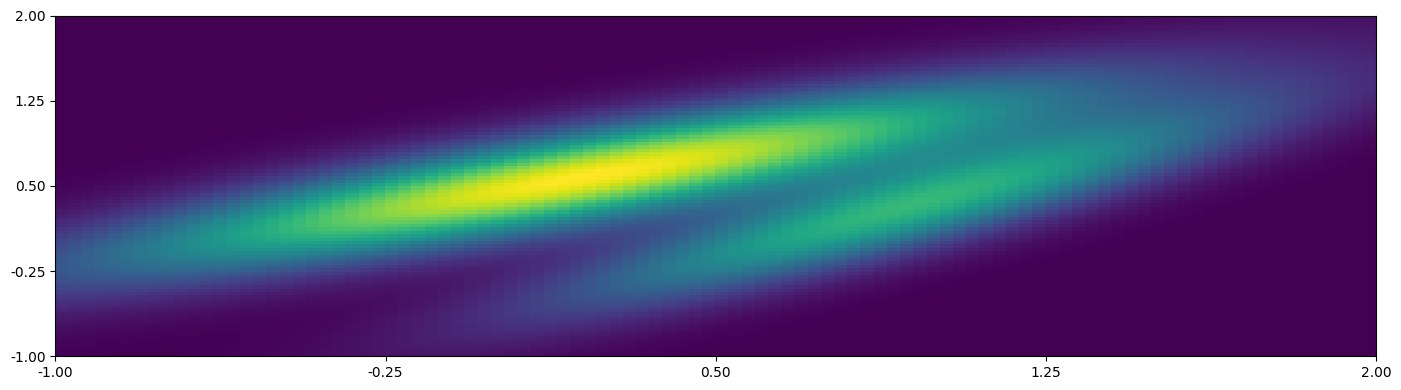

In [2]:
gt = util.generate_gmm_dist(n_components=2, seed=59)
util.plot_density_estimator_2D(gt, xr=np.linspace(-1, 2, 100), yr=np.linspace(-1, 2, 100), figsize=figsize)

* Our example has two components, each with its own mean and covariance
* One component is slightly less prevalent than the other

## GMM Parameters

**The PDF of a GMM is given by:**

$$
g(x, \mu, \Sigma, \tau) = \sum_{k = 1}^{n} \tau_k f(x, \mu_k, \Sigma_k)
$$

* $f$ is the PDF of a multivariante Normal distribution
* $\mu_k$ is the (vector) mean and $\Sigma_k$ the covariance matrix for the $k$-th component
* $\tau_k$ corresponds to $P(Z = k)$

**We can inspect the values for our example GMM**

In [3]:
print('tau:', gt.weights)
print('mu', str(gt.mu).replace('\n', ' '))
print('sigma', str(gt.sigma).replace('\n', ' '))

tau: [0.69756198 0.30243802]
mu [[0.20612642 0.58696692]  [0.94152811 0.3112852 ]]
sigma [array([[0.5610369 , 0.3646768 ],        [0.3646768 , 0.31593376]]), array([[0.29862754, 0.29550211],        [0.29550211, 0.35832187]])]


## Sampling from GMMs

**When we want to _sample_ from a GMM**

* First we need to sample the $Z$ variable
* Then we sample from the corresponding multivariate distribution

In [4]:
train_x, train_z = gt.sample(1000, seed=42)
test_x, test_z = gt.sample(1000, seed=42)

**Hence, we don't get to now just the sample value**

...But also _which of the Gaussian components_ it was generated by

In [5]:
print('z values:', train_z[:4])
print('x values:', train_x[:4])

z values: [0 1 1 0]
x values: [[ 0.25595526  0.24144331]
 [ 0.65952904  0.16087875]
 [ 0.50240258  0.11145718]
 [-0.47036887  0.2317656 ]]


## Training a GMM

**We can train a GMM to _approximate other distributions_**

The training problem can be formulated in terms of _likelihood maximization_

$$\begin{align}
\mathop{\arg\max}_{\mu, \Sigma, \tau}\ & \mathbb{E}_{x \sim X}\left[ L(x, \mu, \Sigma, \tau) \right] \\
\text{s.t. } & \sum_{k=1}^n \tau_k = 1
\end{align}$$

* As usual, the likelihood function $L$ measures how likely it is...
* ...that the training sample $\hat{x}$ is generated by a GMM with parameters $\mu, \Sigma, \tau$

**There's more than one issue here**

...And the first one is dealing with the expectation

## Training a GMM

**We can approximate the expectation by using the training set**

$$
\mathbb{E}_{x \sim X} \left[ L(x, \mu, \Sigma, \tau)\right] \simeq \prod_{i = 1}^m g(x_i, \mu, \Sigma, \tau)
$$

Technically, this is just an example of Monte-Carlo estimation

* When used for the likelihood of the training data
* ...This is often called "Empirical Risk Minimization" principle

**There are two sub-variants of this approach**

* We can use a single large sample (the classical approach)
* ...Or many smaller ones (what we do in cross-validation)

We will stick to the simplest approach (a single training sample)

## Training a GMM

**Let's put everything together**

$$\begin{align}
\mathop{\arg\max}_{\mu, \Sigma, \tau}\ & \prod_{i = 1}^m \sum_{k = 1}^{n} \tau_k f(x, \mu_k, \Sigma_k) \\
\text{s.t. } & \sum_{k=1}^n \tau_k = 1
\end{align}$$

From an optimization point of view, this is _very annoying problem_:

* There's a _constraint_
* There's both _a product and a sum_
* The product cannot be decomposed ($\mu, \Sigma, \tau$ appear in every term)

**So we'll need to get clever!**

## An Apparent Overcomplication

**We get clever by apparently overcomplicating the problem**

In particular, we introduce a random variable $Z_{i}$ _for each example_

* $Z_{i} = k$  iff $i$-th example was drawn from the $k$-th component
* The $Z_{i}$ are _latent_ since we do not know their value
* We focus on _our_ uncertainty, rather than on the uncertainty in the process

**When computin the PDF, we take the values of $Z_i$ for granted:**

$$
\tilde{g}_i(x_i, z_i, \mu, \Sigma, \tau) = \tau_{z_{i}} f(x, \mu_k, \Sigma_k)
$$

* The value $z_i$ is now _an input to $\tilde{g}_i$_
* ...And we can use it as an index to retrieve the correct $\tau_k$
* This alternative PDF is much easier (there is _no sum_)!

## An Apparent Overcomplication

**The drawback is that we have now uncertainty over _both $X$ and all $Z_i$_**

$$
\mathbb{E}_{x \sim X, \{z_i\} \sim \{Z_i\}} \left[ L(x, z, \mu, \Sigma, \tau)\right]
$$

We can deal with $X$ by using the training:s

**By doing this we obtain:**

$$
\mathbb{E}_{x \sim X, \{z_i\} \sim \{Z_i\}} \left[ L(x, z, \mu, \Sigma, \tau)\right] \simeq
\mathbb{E}_{\{z_i\} \sim \{Z_i\}} \left[ \prod_{i=1}^m \tilde{g}_i(x_i, z_i, \mu, \Sigma, \tau) \right]
$$

* We cannot use the same technique for the $Z_i$ variables
* ...Since we do not have a sample for them (they are latent)!

## An Apparent Overcomplication

**We can however compute the expectation _in closed form_**

* We introduce new variables (to be estimated) $\tilde{\tau}_{i,k}$
* ...which represet the (unknown) distribution of the latent $Z_i$ variables

In particular, $\tilde{\tau}_{i,k}$ corresponds to $P(Z_i = k)$

**With the new variable, we can compute the expectation _in closed form_:**

$$
\mathbb{E}_{\hat{x} \sim X, \hat{z} \sim Z} \left[ L(\hat{x}, \hat{z}, \mu, \Sigma, \tau)\right] \simeq
\prod_{i=1}^m \prod_{k=1}^n \tilde{g}_i(x_i, z_i, \mu, \Sigma, \tau)^{\tilde{\tau}_{i,k}}
$$

* Intuitively, we if we sampled $Z_{i}$
* ...We would generate $\tilde{\tau}_{i,k}$ samples for each component $k$
* ...So that the corresponding density is multplied by itself $\tilde{\tau}_{i,k}$ times

## An Apparent Overcomplication

**The reworked training problem therefore is**

$$\begin{align}
\mathop{\arg\max}_{\mu, \Sigma, \tau, \tilde{\tau}}\ & \prod_{i=1}^m \prod_{k=1}^n \tilde{g}_i(x_i, z_i, \mu, \Sigma, \tau)^{\tilde{\tau}_{i,k}} \\
\text{s.t. } & \sum_{k=1}^n \tau_k = 1 \\
 & \sum_{k=1}^n \tilde{\tau}_{i,k} = 1 \quad\quad \forall i = 1..m
\end{align}$$

* We have even more variables (the $\tilde{\tau}_{i,k}$ ones)
* ...But they are statistically related! Each $Z_i$ is drawn from $Z$
* ...And there's no longer a combination of sums and products

## Expectation-Maximization

**We can now use the [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm)**

The EM algorithm is an optimization method based on _alternating steps_

* In the _expectation_ step:
  - We consider $\mu, \Sigma, \tau$ as fixed and we optimize over $\tilde{\tau}$
  - ...I.e. we try to estimate how sampling went
  - After this, we compute the expectation over $Z$ (in a symbolic form)
* In the _maximization_ step:
  - We use the (symbolic) expectation over $Z$ from before
  - We consider $\tilde{\tau}$ as fixed and we optimize over $\mu, \Sigma, \tau$

**The method converges to a local optimum**

...And we will not detail it further in this lecture

## GMM in Action

**There are many implementations and variants of the EM method**

We will use the code from scikit-learn:

In [6]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=4)
gm.fit(train_x);

* The API is the usual one

**We need to specify the number of components a priori**

* We can tune it using a maximum likelihood approach on a validation set
* ...Or using other criteria (e.g. elbow method)  

## Inspecting the Results

**Let's inspect the learned parameters**

In [7]:
print('Learned weights', gm.weights_)
print('True weights', gt.weights)

Learned weights [0.6590098 0.3409902]
True weights [0.69756198 0.30243802]


In [8]:
print('Learned means', str(gm.means_).replace('\n', ' '))
print('True means', str(gt.mu).replace('\n', ' '))

Learned means [[0.06974974 0.54625223]  [0.96907679 0.40083217]]
True means [[0.20612642 0.58696692]  [0.94152811 0.3112852 ]]


In [9]:
print('Learned covariance #1', str(gm.covariances_[0]).replace('\n', ' '))
print('True covariance #1', str(gt.sigma[0]).replace('\n', ' '))
print('Learned covariance #2', str(gm.covariances_[1]).replace('\n', ' '))
print('True covariance #2', str(gt.sigma[1]).replace('\n', ' '))

Learned covariance #1 [[0.47861885 0.32101492]  [0.32101492 0.28622476]]
True covariance #1 [[0.5610369  0.3646768 ]  [0.3646768  0.31593376]]
Learned covariance #2 [[0.26613038 0.26083955]  [0.26083955 0.34615556]]
True covariance #2 [[0.29862754 0.29550211]  [0.29550211 0.35832187]]


## Inspecting the Results

**Here is the approximated PDF**

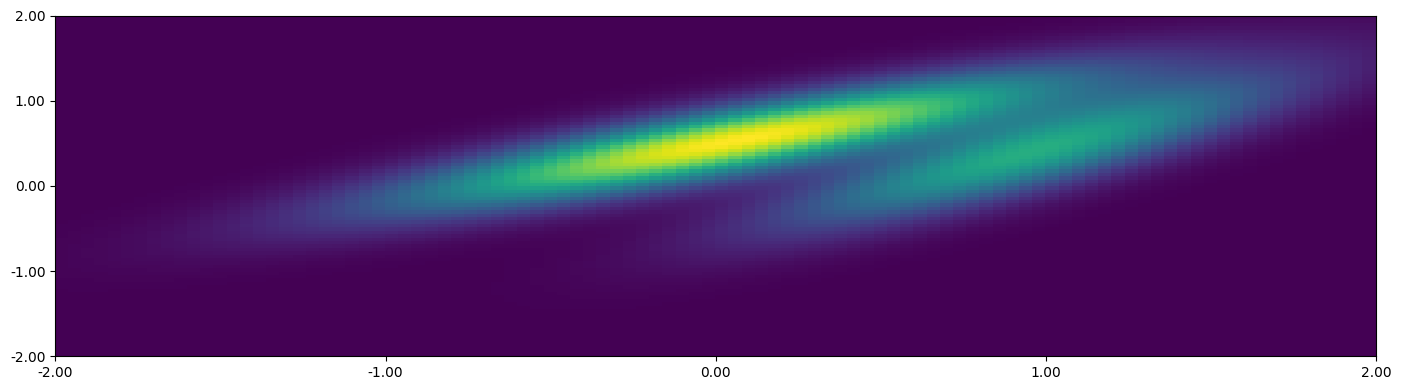

In [10]:
util.plot_density_estimator_2D(gm, xr=np.linspace(-2, 2, 100), yr=np.linspace(-2, 2, 100), figsize=figsize)

## Which Kind of Prediction

**GMMs are very flexible in terms of what they can do**

We can use them to _evaluate the (log) density_ of a sample:

In [11]:
pred_lf = np.exp(gm.score_samples(train_x))
print('Log densities:', pred_lf[:3])

Log densities: [0.17629181 0.29102933 0.21023248]


We can use them to _generate a sample_:

In [12]:
pred_x, pred_z = gm.sample(3)
print('Sampled values:', str(pred_x).replace('\n', ' '))
print('Sampled components:', pred_z)

Sampled values: [[ 0.74060004  0.14883754]  [ 0.31220378 -0.02384664]  [ 0.30811268 -0.47618621]]
Sampled components: [1 1 1]


## More then Densities

**GMMs are very flexible in terms of what they can do**

We can estimate the _probability that a sample belongs to a component_

In [13]:
pred_p = gm.predict_proba(train_x)
print('Probability of belonging to a component:')
print(pred_p[:3])

Probability of belonging to a component:
[[0.84724085 0.15275915]
 [0.01845649 0.98154351]
 [0.05474391 0.94525609]]


* The approach is the same we used to optimize $\tilde{\tau}_{i,k}$ in the expectation step

By picking the maximum probability, we can _assign samples to a component_ 

In [14]:
pred_c = gm.predict(train_x)
print(pred_c[:3])

[0 1 1]


## More then Densities

**GMMs can certainly act as density estimators**

...But can do much more!

* Sampling
* Component assignment
* ...And therefore _clustering_

This is so true that GMM are often presented as a generalization of k-means

**And this (partially) addresses the last limitation of KDE**

* By choosing certain density estimator
* ...We can obtain additional information in addition to the densities